In [100]:
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch
import os
from pathlib import Path
import glob
import torch.nn as nn
from itertools import chain
import torch.optim as optim
import time
from progressbar import ETA, Bar, Percentage, ProgressBar
import simpleaudio as sa
# from model_Adp import *
from model_Adp_custom import *
import scipy.io as sio
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.transforms.functional import pad
from torch.utils.data import Dataset
import torchvision.utils as vutils
from torchvision.transforms import *
import torchvision
from collections import defaultdict
from IPython.display import Audio, display
import torchaudio
from torchvision.transforms.functional import pad
from matplotlib.lines import Line2D
import noisereduce as nr

import joblib

import librosa
from tqdm import tqdm

from utils import audio_tools as audio
from utils.hparams import *

In [2]:
SR = hparams['sample_rate']
num_mels = hparams['num_mels']
IMAGE_SIZE = 512

In [153]:
spect_dir_A = "../../../scratch/sram/CMU/A_spect"
spect_dir_B = "../../../scratch/sram/CMU/B_spect"

class TIMITDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_path = glob.glob(self.img_dir+"*.npy")

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img_path = self.img_path[idx]
        image = np.load(img_path)
        # image = padding(image, 128, 128)
        if self.transform:
            image = self.transform(image)  
            
        image = image.type(torch.FloatTensor)
    
        return image

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [448]:
data = TIMITDataset(spect_dir_B, transform=transform)
data = list(iter(data))[10]#[2398]

In [449]:
true = torch.reshape(data, (1,1,num_mels,IMAGE_SIZE))

In [450]:
gen = "A"

generator = torch.load("results/CMU_Adam_lr0.0002_lr_decay0_starting_rate0.01_default_rate0.5/models/impersonation/spec_gan/model_gen_"+gen+"-0.0")
generator.eval()

DataParallel(
  (module): Generator(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [451]:
pred, _, _ = generator(true)

In [452]:
pred = pred.cpu().detach().numpy()

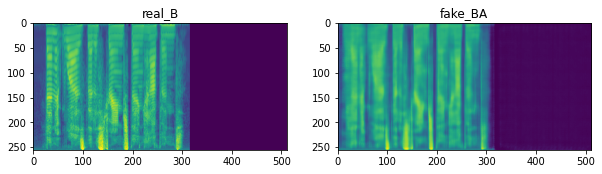

In [453]:
# Display image.
fig, axs = plt.subplots(1,2, figsize=(10,10))

axs[0].imshow(true.squeeze())
axs[0].set_title("real_B")

axs[1].imshow(pred.squeeze())
axs[1].set_title("fake_BA")

plt.savefig( "results/misc/generation.jpg", dpi = 300, bbox_inches='tight')
plt.show()

In [454]:
print(pred)

[[[[-0.38597772 -0.32166967 -0.2937782  ... -0.96758944 -0.9663054
    -0.90052444]
   [-0.47995558 -0.3147618  -0.29847157 ... -0.97934926 -0.96507823
    -0.9725697 ]
   [-0.47345302 -0.33704352 -0.33512312 ... -0.97441757 -0.9770371
    -0.9750048 ]
   ...
   [-0.15174173 -0.14555031 -0.13534437 ... -0.9781423  -0.9647978
    -0.9625902 ]
   [-0.09643725 -0.08235541 -0.12246969 ... -0.9516783  -0.9782288
    -0.94612193]
   [-0.08152525 -0.09044027 -0.10903166 ... -0.9361654  -0.94371706
    -0.8738688 ]]]]


In [455]:
path_A = "../../../scratch/sram/CMU/A"
path_B = "../../../scratch/sram/CMU/B"

n = 1000

files_A = glob.glob(path_A+"/*.wav")[:n]
files_B = glob.glob(path_B+"/*.wav")[:n]

def load_audio(path):
    y, sr = librosa.core.load(path, sr = SR)

    # sfft -> mel conversion
    db_mel = audio.melspectrogram(y)

    # means/standard diviation for each freq bin
    m_db_mel = np.mean(db_mel, axis=1)
    std_db_mel = np.std(db_mel, axis=1)
    return m_db_mel, std_db_mel

def parallel_loading(files):
    # parallel loading
    results = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(load_audio)(path) for path in files)

    means = [mean for mean, _ in results if mean is not None]
    stds = [std for _, std in results if std is not None]

    # calcurate overall means/standard diviation
    means = np.array(means)
    stds = np.array(stds)

    mel_means = np.mean(means, axis=0)
    mel_stds = np.mean(stds, axis=0)
    
    return mel_means, mel_stds

In [456]:
def denormalize(norm_s, mel_means, mel_stds):
    assert norm_s.shape[0] == mel_means.shape[0]
    Y = (norm_s * (3.0 * mel_stds[:,None])) + mel_means[:,None]
    return Y

In [457]:
mel_means_pred, mel_stds_pred = parallel_loading(files_A)
mel_means_true, mel_stds_true = parallel_loading(files_B)

In [458]:
speech_pred = denormalize(pred.reshape(num_mels,IMAGE_SIZE), mel_means_pred, mel_stds_pred)
speech_true = denormalize(true.reshape(num_mels,IMAGE_SIZE), mel_means_true, mel_stds_true)

speech_pred = audio.inv_melspectrogram(speech_pred)
speech_true = audio.inv_melspectrogram(speech_true)

speech_pred = nr.reduce_noise(y=speech_pred, sr=SR)
speech_true = nr.reduce_noise(y=speech_true, sr=SR)

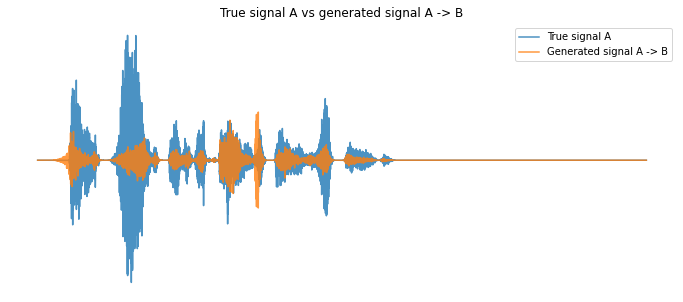

In [459]:
# Display image.
fig, axs = plt.subplots(figsize=(12,5))
axs.set_axis_off()
plt.title("True signal A vs generated signal A -> B")
plt.plot(speech_true, alpha=0.8, label="True signal A")
plt.plot(speech_pred, alpha=0.8, label="Generated signal A -> B")
plt.legend()

plt.savefig("results/misc/signal.jpg", dpi = 300, bbox_inches='tight')

plt.show()

In [460]:
audio.save_wav(speech_true, "./true.wav")
audio.save_wav(speech_pred, "./pred.wav")

In [461]:
def play_audio(waveform, sample_rate):  
    waveform = waveform.reshape(1,waveform.shape[0])
    
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [462]:
play_audio(speech_true, SR)
play_audio(speech_pred, SR)

/home/sram/VoiceGANmodel/utils/audio_tools.py:83: FutureWarning: Pass sr=16000, n_fft=2024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(hparams['sample_rate'], n_fft, n_mels=hparams['num_mels'])
/home/sram/VoiceGANmodel/utils/audio_tools.py:83: FutureWarning: Pass sr=16000, n_fft=2024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(hparams['sample_rate'], n_fft, n_mels=hparams['num_mels'])
/home/sram/VoiceGANmodel/utils/audio_tools.py:83: FutureWarning: Pass sr=16000, n_fft=2024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.filters.mel(hparams['sample_rate'], n_fft, n_mels=hparams['num_mels'])
/home/sram/VoiceGANmodel/utils/audio_tools.py:83: FutureWarning: Pass sr=16000, n_fft=2024 as keyword args. From version 0.10 passing these as positional arguments will res